In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
import os
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

import matplotlib.pyplot as plt

class ConfigStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [3]:
config = dict(
    epochs=600,
    batch_size=2048,
    learning_rate=0.008,
    weight_decay=1e-5,
    dropout=0.05,
    shuffle=True,
    test_size=0.2,
    split_seed=42,
    random_seed=1234,
    stratified_split=False,
    smooth_l1_loss_beta=1.0
)

In [4]:
MODEL_FILENAME = "SmoothL1Loss_fixed_Adamax_fewer_neurons_0.2_testSize_new_StandardScaler_2048_batch_0.05_dropout_pytorch_v1.12.tar"
MODEL_DIR = "../models"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME)

DATASET_DIR = "../data"
DATASET_NAME = "blue_waters_posix_all_no_outliers"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME).with_suffix(".csv")

CSV_LOG_PATH = "Train_Full_Dataset_test_loss.csv"

In [5]:
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "test_loss"])

In [6]:
# Load the data
df_blue_waters_posix = pd.read_csv(DATASET_PATH)
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,49152,-24576,-24576,0,0,0,24576,0,0,-24576,...,0.0,0.000000,1513942235,1513942281,24,47.0,3.1,/u/system/bwjenkins/mdtest-jenkins/mdtest/mdte...,0,0.000000
1,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.135492,1513986144,1513986162,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,255.557572
2,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.162338,1513991554,1513991572,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,226.638510
3,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.193178,1513992459,1513992477,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,180.999088
4,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.205942,1513987749,1513987767,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,187.159073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724026,8709,-288,-288,1398193,6331987,2021535,28430,0,0,-288,...,0.0,80.506971,1531513254,1531513957,256,704.0,3.1,CCTM_v52_Linux2_x86_64intel,1,259.932043
724027,8709,-288,-288,1393841,6331677,2015391,28430,0,0,-288,...,0.0,63.564875,1531508939,1531509581,256,643.0,3.1,CCTM_v52_Linux2_x86_64intel,1,356.765856
724028,8709,-288,-288,1398193,6327571,2013855,28430,0,0,-288,...,0.0,59.515109,1531556071,1531556744,256,674.0,3.1,CCTM_v52_Linux2_x86_64intel,1,358.838439
724029,8709,-288,-288,1396913,6329542,2010527,28430,0,0,-288,...,0.0,112.244880,1531511947,1531512674,256,728.0,3.1,CCTM_v52_Linux2_x86_64intel,1,307.633323


In [7]:
# Remove all records with zero in the "bandwidth" column
df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix["bandwidth"] != 0]
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
1,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.135492,1513986144,1513986162,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,255.557572
2,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.162338,1513991554,1513991572,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,226.638510
3,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.193178,1513992459,1513992477,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,180.999088
4,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.205942,1513987749,1513987767,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,187.159073
5,1747,-130,-130,86885,35912,85705,3365,0,0,-130,...,0.0,0.271263,1513988529,1513988547,128,19.0,3.1,enzo.exe -d -r DD0601/DD0601,1,133.881110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724026,8709,-288,-288,1398193,6331987,2021535,28430,0,0,-288,...,0.0,80.506971,1531513254,1531513957,256,704.0,3.1,CCTM_v52_Linux2_x86_64intel,1,259.932043
724027,8709,-288,-288,1393841,6331677,2015391,28430,0,0,-288,...,0.0,63.564875,1531508939,1531509581,256,643.0,3.1,CCTM_v52_Linux2_x86_64intel,1,356.765856
724028,8709,-288,-288,1398193,6327571,2013855,28430,0,0,-288,...,0.0,59.515109,1531556071,1531556744,256,674.0,3.1,CCTM_v52_Linux2_x86_64intel,1,358.838439
724029,8709,-288,-288,1396913,6329542,2010527,28430,0,0,-288,...,0.0,112.244880,1531511947,1531512674,256,728.0,3.1,CCTM_v52_Linux2_x86_64intel,1,307.633323


In [8]:
# Separate bandwidth from input features
bandwidth_df = df_blue_waters_posix.pop('bandwidth')
bandwidth_df

1         255.557572
2         226.638510
3         180.999088
4         187.159073
5         133.881110
             ...    
724026    259.932043
724027    356.765856
724028    358.838439
724029    307.633323
724030    325.812885
Name: bandwidth, Length: 682576, dtype: float64

In [9]:
# Fix seeds for reproducibility
random.seed(config["random_seed"])
np.random.seed(config["random_seed"])

torch.manual_seed(config["random_seed"])
torch.cuda.manual_seed_all(config["random_seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
config = ConfigStruct(**config)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_blue_waters_posix,
                                                    bandwidth_df,
                                                    test_size=config.test_size,
                                                    random_state=config.split_seed,
                                                    stratify=df_blue_waters_posix["nprocs"] if config.stratified_split else None)

In [12]:
non_numeric_columns = X_train.select_dtypes(include='object').columns
non_numeric_columns

Index(['exe'], dtype='object')

In [13]:
X_train = X_train.drop(columns=non_numeric_columns)
X_train

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,lustre
296527,822,-20,-20,110465,37166667,15524,838,0,0,-20,...,0.092333,0.826430,0.0,194.747003,1567923696,1567926192,16,2497.0,3.1,1
122405,1352,-1352,-1352,2031,0,0,2704,0,0,-1352,...,0.000067,0.000000,0.0,0.000000,1564903499,1564903528,675,30.0,3.1,1
21959,280,-20,-20,83944,21344341,4170,284,0,0,-20,...,0.063586,0.946407,0.0,153.113806,1567746975,1567750396,4,3422.0,3.1,1
410045,7866,-1146,-1146,3674640,2958150,5804363,123336,0,1,-1146,...,0.613986,0.472326,0.0,0.585018,1524528146,1524611848,48,83703.0,3.1,1
230143,194,-13,-13,91456,10983,92,386,0,0,-13,...,0.026780,0.074779,0.0,0.701241,1553105031,1553105053,32,23.0,3.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277586,114,-13,-13,45728,10983,76,226,0,0,-13,...,0.029194,0.069411,0.0,0.328191,1556631881,1556632392,16,512.0,3.1,1
389701,172,-73,-73,24357,1370,325,270,0,0,-73,...,0.014081,0.001202,0.0,0.028336,1548344632,1548344741,32,110.0,3.1,1
141670,20785,-2688,-2688,515752,233072,668949,56481,0,1,-2688,...,0.766702,2.786326,0.0,0.471844,1550673119,1550673809,96,691.0,3.1,1
711589,19070,-1059,-1059,3899922,3330114,5444823,371568,0,1,-1059,...,0.157623,5.418913,0.0,0.486078,1506320503,1506404345,48,83843.0,3.1,1


In [14]:
X_test = X_test.drop(columns=non_numeric_columns)
X_test

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,lustre
152261,8305,-1057,-1057,1844644,1427016,2762476,119042,0,1,-1057,...,0.835523,0.679153,0.0,0.720676,1544608669,1544644629,64,35961.0,3.1,1
676447,1875,-782,-782,462627,7675,2568,3426,0,0,-782,...,0.248775,0.324143,0.0,2.029297,1529672110,1529672162,64,53.0,3.1,1
258891,853,-366,-366,65442,28679,23765,2027,0,0,-366,...,0.072432,0.039495,0.0,0.054068,1576333706,1576333925,64,220.0,3.1,1
147280,115,-13,-13,45728,10984,77,228,0,0,-13,...,0.026495,0.078265,0.0,0.584632,1568951444,1568951567,16,124.0,3.1,1
363974,79581,-1314,-1314,4110961,1091727,2100999,372262,0,1,-1314,...,2.527219,3.397837,0.0,21.141853,1538835557,1538852816,32,17260.0,3.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289200,882,-20,-20,130461,30116724,15882,898,0,0,-20,...,0.139485,1.482586,0.0,245.685521,1567998212,1568001689,16,3478.0,3.1,1
242882,403,-268,-268,35586,3317,5461,937,0,0,-268,...,0.169016,0.366854,0.0,0.054473,1575679142,1575680299,32,1158.0,3.1,1
717726,8709,-288,-288,1444606,6400178,2067127,28430,0,0,-288,...,0.850249,0.315367,0.0,207.796600,1510460994,1510461829,256,836.0,3.1,1
439074,974,-975,-975,1463,0,0,1949,0,0,-975,...,0.037462,0.000000,0.0,0.000000,1541527480,1541527533,486,54.0,3.1,1


In [15]:
scaler = StandardScaler().fit(X_train)

In [16]:
# Scale the input features
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-1.98683963e-02,  4.67428784e-02,  4.67428784e-02, ...,
        -4.10562397e-01,  3.55271368e-15,  1.70126200e-02],
       [-1.93772541e-02, -7.45738416e-04, -7.45738416e-04, ...,
        -4.99401561e-01,  3.55271368e-15,  1.70126200e-02],
       [-2.03706586e-02,  4.67428784e-02,  4.67428784e-02, ...,
        -3.77252212e-01,  3.55271368e-15,  1.70126200e-02],
       ...,
       [-1.36901859e-03, -4.83769637e-02, -4.83769637e-02, ...,
        -4.75598283e-01,  3.55271368e-15,  1.70126200e-02],
       [-2.95828036e-03,  9.70033120e-03,  9.70033120e-03, ...,
         2.51878930e+00,  3.55271368e-15,  1.70126200e-02],
       [ 2.47069213e-02, -1.85361437e-02, -1.85361437e-02, ...,
         5.08978766e-01,  3.55271368e-15,  1.70126200e-02]],
      shape=(546060, 102))

In [17]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_train = torch.Tensor(X_train_scaled).to(device)
tensor_X_train

tensor([[-1.9868e-02,  4.6743e-02,  4.6743e-02,  ..., -4.1056e-01,
          3.5527e-15,  1.7013e-02],
        [-1.9377e-02, -7.4574e-04, -7.4574e-04,  ..., -4.9940e-01,
          3.5527e-15,  1.7013e-02],
        [-2.0371e-02,  4.6743e-02,  4.6743e-02,  ..., -3.7725e-01,
          3.5527e-15,  1.7013e-02],
        ...,
        [-1.3690e-03, -4.8377e-02, -4.8377e-02,  ..., -4.7560e-01,
          3.5527e-15,  1.7013e-02],
        [-2.9583e-03,  9.7003e-03,  9.7003e-03,  ...,  2.5188e+00,
          3.5527e-15,  1.7013e-02],
        [ 2.4707e-02, -1.8536e-02, -1.8536e-02,  ...,  5.0898e-01,
          3.5527e-15,  1.7013e-02]], device='cuda:0')

In [18]:
tensor_y_train = torch.Tensor(y_train.values).view(-1, 1).to(device)  
tensor_y_train

tensor([[ 26.2419],
        [  0.4312],
        [ 18.8668],
        ...,
        [150.4743],
        [145.8939],
        [117.5636]], device='cuda:0')

In [19]:
training_dataset = TensorDataset(tensor_X_train, tensor_y_train)
training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=config.shuffle)

In [20]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-1.29340255e-02,  9.77163543e-03,  9.77163543e-03, ...,
         7.94510072e-01,  3.55271368e-15,  1.70126200e-02],
       [-1.88925988e-02,  1.95759670e-02,  1.95759670e-02, ...,
        -4.98573308e-01,  3.55271368e-15,  1.70126200e-02],
       [-1.98396691e-02,  3.44072467e-02,  3.44072467e-02, ...,
        -4.92559469e-01,  3.55271368e-15,  1.70126200e-02],
       ...,
       [-1.25596455e-02,  3.71881116e-02,  3.71881116e-02, ...,
        -4.70376686e-01,  3.55271368e-15,  1.70126200e-02],
       [-1.97275404e-02,  1.26951088e-02,  1.26951088e-02, ...,
        -4.98537297e-01,  3.55271368e-15,  1.70126200e-02],
       [-2.04318197e-02,  4.69567911e-02,  4.69567911e-02, ...,
        -4.94900185e-01,  3.55271368e-15,  1.70126200e-02]],
      shape=(136516, 102))

In [21]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_test = torch.Tensor(X_test_scaled).to(device)
tensor_X_test

tensor([[-1.2934e-02,  9.7716e-03,  9.7716e-03,  ...,  7.9451e-01,
          3.5527e-15,  1.7013e-02],
        [-1.8893e-02,  1.9576e-02,  1.9576e-02,  ..., -4.9857e-01,
          3.5527e-15,  1.7013e-02],
        [-1.9840e-02,  3.4407e-02,  3.4407e-02,  ..., -4.9256e-01,
          3.5527e-15,  1.7013e-02],
        ...,
        [-1.2560e-02,  3.7188e-02,  3.7188e-02,  ..., -4.7038e-01,
          3.5527e-15,  1.7013e-02],
        [-1.9728e-02,  1.2695e-02,  1.2695e-02,  ..., -4.9854e-01,
          3.5527e-15,  1.7013e-02],
        [-2.0432e-02,  4.6957e-02,  4.6957e-02,  ..., -4.9490e-01,
          3.5527e-15,  1.7013e-02]], device='cuda:0')

In [22]:
tensor_y_test = torch.Tensor(y_test.values).view(-1, 1).to(device)  
tensor_y_test

tensor([[3.4453e+01],
        [1.0427e+02],
        [2.6210e+02],
        ...,
        [3.9978e+02],
        [3.2032e-01],
        [3.6584e+01]], device='cuda:0')

In [23]:
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size)

In [24]:
model = nn.Sequential(
    nn.Linear(102, 2048),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1),
).to(device)

In [25]:
loss_fn = nn.SmoothL1Loss(beta=config.smooth_l1_loss_beta, reduction="sum").to(device)

optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [26]:
model_epoch = 0

In [27]:
# Load previously trained state if available
if Path(MODEL_PATH).is_file():
    print("Loading pretrained model...")

    checkpoint = torch.load(MODEL_PATH, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    model_epoch = checkpoint['epoch']

    print(f"Current epoch: {model_epoch}")

model.train()

Sequential(
  (0): Linear(in_features=102, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [28]:
def train():
    size = len(training_dataloader)
    for batch, (X, y) in enumerate(training_dataloader):
        y_pred = model(X)

        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss = loss.item()
        #     print(f"loss: {loss:>7f} [{batch:>5d}/{size:>5d}]")

    model.train()

In [29]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(test_dataloader.dataset)

    # print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss

In [30]:
test_losses = []

for epoch in range(model_epoch, config.epochs):
    # print(f"Epoch {epoch + 1}\n-------------------------------")
    train()
    test_loss = test()

    scheduler.step(test_loss)

    model_epoch = epoch
    test_losses.append(test_loss)

    with open(CSV_LOG_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, test_loss])

    torch.save({
        'epoch': model_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, MODEL_PATH)

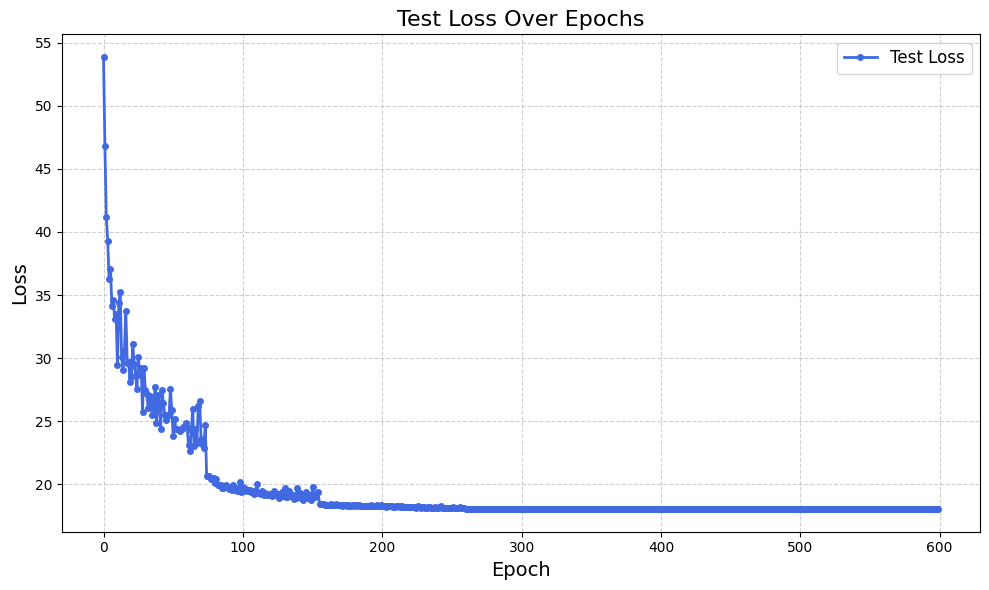

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='royalblue', linewidth=2, marker='o', markersize=4)

plt.title("Test Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()